In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

First we define a positional encoding for the time input to the UNet.

In [2]:
class SinusoidalPositionalEncoding(nn.Module):
    """A sinusoidal positional encoding module.
    
    This module implements a fixed positional encoding scheme that 
    generates sinusoidal positional encodings for input timesteps 
    via the standard transformer-style sinusoidal pattern:
    PE(t, 2i) = sin(t / 10000^(2i/d))
    PE(t, 2i+1) = cos(t / 10000^(2i/d))
    where d is the encoding dimension dimension and i is the dimension index.

    Attributes:
        timestep_dim (int): The base dimension of the positional encoding
    """

    def __init__(
        self,
        base_dim: int,  # 128
    ):
        """Initialize the SinusoidalPositionalEncoding module.
        
        Args:
            base_dim: The base dimension of the positional encoding. 
                      Must be even (will be padded if odd in input).
        
        Raises:
            AssertionError: If base_dim is not even.
        """
        super().__init__()
        
        assert(base_dim % 2 == 0)
        self.timestep_dim = base_dim
        
        self.register_buffer(
            'inv_freq',
            1.0 / (10_000 ** (torch.arange(0, self.timestep_dim, 2).float() / self.timestep_dim)),
            persistent=False
        )
     

    def forward(self, picked_up_timesteps: torch.Tensor) -> torch.Tensor:
        """Forward pass of the positional encoding module.
        
        Args:
            picked_up_timesteps: Input tensor containing timestep values.
                                Shape: (batch_size,)
                                
        Returns:
            torch.Tensor: Positional encodings.
                         Shape: (batch_size, base_dim)
                         
        Processing steps:
            1. Computes sinusoidal positional encodings for input timesteps
        """
        t = picked_up_timesteps.unsqueeze(1) # add dim 1
        inv_freq = self.inv_freq.unsqueeze(0) # add dim 0
        theta = t * inv_freq # t / (10_000)^(2i/d)
        sines = torch.sin(theta)
        cosines = torch.cos(theta)
        out = torch.empty((sines.shape[0], 2*sines.shape[1]))
        out[:, 0::2] = sines
        out[:, 1::2] = cosines
        return out

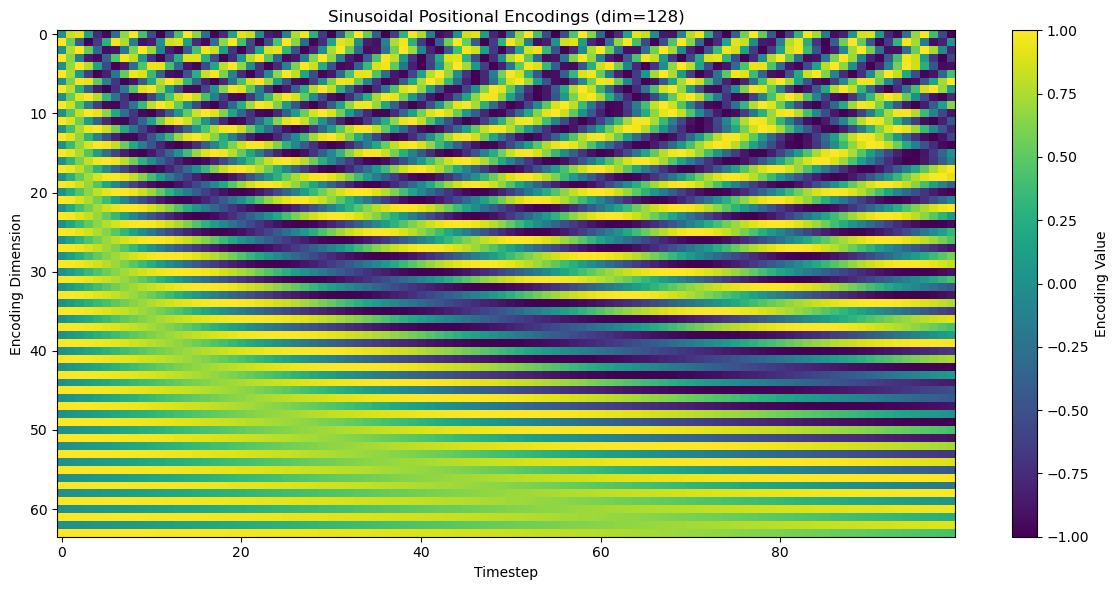

In [3]:
base_dim = 128
timesteps = 100
s = SinusoidalPositionalEncoding(base_dim)
t = torch.arange(0, timesteps)
encodings = s.forward(t)

# Convert to numpy for plotting
encodings_np = encodings.numpy()
encodings_np = encodings_np[: , :base_dim//2]

# Create the plot
plt.figure(figsize=(12, 6))

# Create heatmap
im = plt.imshow(encodings_np.T, aspect='auto', cmap='viridis')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Encoding Value')

# Customize axes
plt.xlabel('Timestep')
plt.ylabel('Encoding Dimension')
plt.title(f'Sinusoidal Positional Encodings (dim={base_dim})')

# Show plot
plt.tight_layout()
plt.show()


In [4]:
class PositionalEncoding(SinusoidalPositionalEncoding):
    """A sinusoidal positional encoding module with feedforward transformation.
    
    This module implements a learnable positional encoding scheme that:
    1. Generates sinusoidal positional encodings for input timesteps
    2. Applies a two-layer feedforward network to transform the encodings
    
    The positional encoding follows the standard transformer-style sinusoidal pattern:
    PE(t, 2i) = sin(t / 10000^(2i/d))
    PE(t, 2i+1) = cos(t / 10000^(2i/d))
    where d is the base dimension and i is the dimension index.

    Attributes:
        timestep_dim (int): The base dimension of the positional encoding
        hidden1 (nn.Linear): First linear transformation layer
        hidden2 (nn.Linear): Second linear transformation layer
    """

    def __init__(
        self,
        base_dim: int,  # 128
        hidden_dim: int,  # 256
        output_dim: int,  # 512
    ):
        """Initialize the PositionalEncoding module.
        
        Args:
            base_dim: The base dimension of the positional encoding. 
                      Must be even (will be padded if odd in input).
            hidden_dim: Dimension of the hidden layer in the feedforward network.
            output_dim: Dimension of the output layer in the feedforward network.
            
        Raises:
            AssertionError: If base_dim is not even.
        """
        super().__init__(base_dim)
        self.linear1 = nn.LazyLinear(base_dim, hidden_dim)
        self.linear2 = nn.LazyLinear(hidden_dim, output_dim)
        
    def forward(self, picked_up_timesteps: torch.Tensor) -> torch.Tensor:
        """Forward pass of the positional encoding module.
        
        Args:
            picked_up_timesteps: Input tensor containing timestep values.
                                Shape: (batch_size,)
                                
        Returns:
            torch.Tensor: Transformed positional encodings.
                         Shape: (batch_size, output_dim)
                         
        Processing steps:
            1. Computes sinusoidal positional encodings for input timesteps
            2. Flattens the encodings
            3. Applies two-layer feedforward network with SiLU activation
        """
        x = super().forward(picked_up_timesteps)
        x = self.linear1(x)
        x = F.silu(x)
        x = self.linear2(x)
        return x

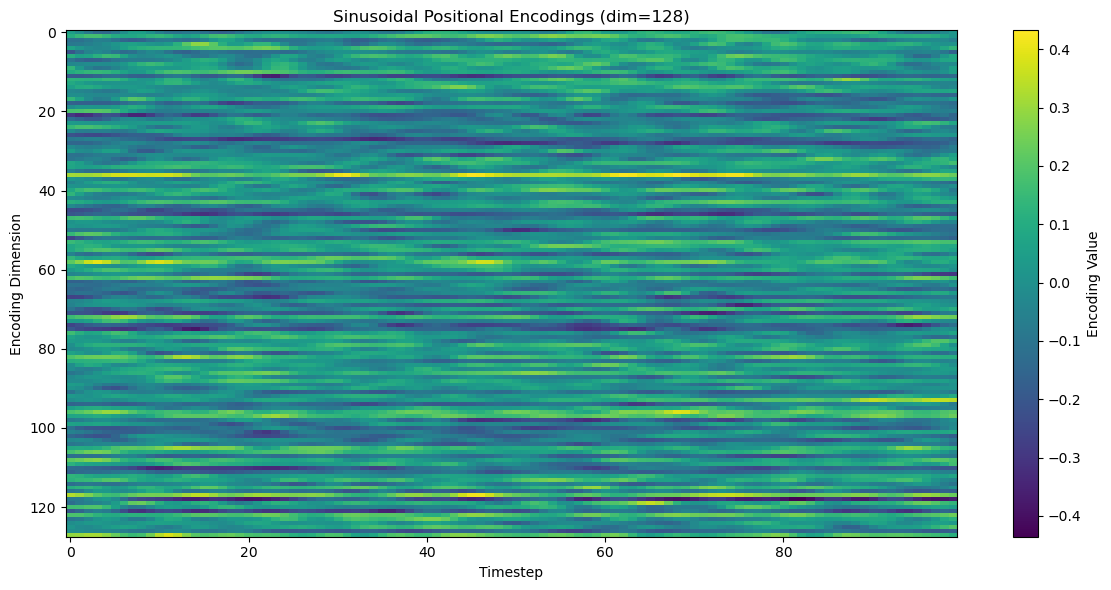

In [5]:
base_dim = 128
timesteps = 100
s = PositionalEncoding(base_dim, base_dim, base_dim)
t = torch.arange(0, timesteps)
encodings = s.forward(t)

# Convert to numpy for plotting
encodings_np = encodings.detach().numpy()
encodings_np = encodings_np[: , :base_dim]

# Create the plot
plt.figure(figsize=(12, 6))

# Create heatmap
im = plt.imshow(encodings_np.T, aspect='auto', cmap='viridis')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Encoding Value')

# Customize axes
plt.xlabel('Timestep')
plt.ylabel('Encoding Dimension')
plt.title(f'Sinusoidal Positional Encodings (dim={base_dim})')

# Show plot
plt.tight_layout()
plt.show()
